In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from urllib.request import urlopen
import plotly
import plotly.graph_objects as go
import geopandas as gpd
import geopandas 
from geodatasets import get_path
from plotly.subplots import make_subplots
from matplotlib.ticker import PercentFormatter


# The client 

My client is Zachary Brooks and	he wants to sell

Usually he invests in historical houses (yr_build < 1965)

in the best neighborhoods (top 15 zipcode with highest average grade and the highest average price / sqft)
he wants to know the best timing within a year for highest profits 

wonders if he should renovate

# The main hypothesis 
 - There is a period during the year when most houses are sold 
- There is a perido during the year when the average house price is higher
- renovated buildings are more expensive then others 
- certain house features increase the price  


# Let's first import the 'presorted' dataframe

In [3]:
df_housing = pd.read_csv('data/eda.csv')

In [4]:
df_housing.head()

,date,price,house_id,id,bedrooms,bathrooms,sqft_lot,sqft_living,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,7129300520,1,3.0,1.00,5650.0,1180.0,1.0,NaN,...,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0
1,2014-12-09,538000.0,6414100192,2,3.0,2.25,7242.0,2570.0,2.0,0.0,...,7,2170.0,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0
2,2015-02-25,180000.0,5631500400,3,2.0,1.00,10000.0,770.0,1.0,0.0,...,6,770.0,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0
3,2014-12-09,604000.0,2487200875,4,4.0,3.00,5000.0,1960.0,1.0,0.0,...,7,1050.0,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0
4,2015-02-18,510000.0,1954400510,5,3.0,2.00,8080.0,1680.0,1.0,0.0,...,8,1680.0,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0


In [5]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   id             21597 non-null  int64  
 4   bedrooms       21597 non-null  float64
 5   bathrooms      21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   sqft_living    21597 non-null  float64
 8   floors         21597 non-null  float64
 9   waterfront     19206 non-null  float64
 10  view           21534 non-null  float64
 11  condition      21597 non-null  int64  
 12  grade          21597 non-null  int64  
 13  sqft_above     21597 non-null  float64
 14  sqft_basement  21145 non-null  float64
 15  yr_built       21597 non-null  int64  
 16  yr_renovated   17749 non-null  float64
 17  zipcode        21597 non-null  int64  
 18  lat   

We are missing infos on the sqft_basement, waterfront and, yr_renovated which is a bit unfortunate since our client is interested in renovation and they have historical houses so the yr_renovated is relevant for our approach

# Now we can start to make the dataframe usable (clean it up a bit)

In [6]:
df_housing['waterfront'].unique() # only nan, 0= no waterfront  and 1= waterfront self explanatory

array([nan,  0.,  1.])

In [7]:
df_housing['condition'].unique()
# conditions range from 1 to 5 with one being the worst and 5 being the best 

array([3, 5, 4, 1, 2])

In [8]:
df_housing['view'].unique()
# view i am not sure about that. I will set it as it has a view from 0 to 4 directions 

array([ 0., nan,  3.,  4.,  2.,  1.])

In [9]:
df_housing['yr_renovated'].unique() # this looks funny I assume it should be a year  I am going to transforming it 

array([    0., 19910.,    nan, 20020., 20100., 19920., 20130., 19940.,
       19780., 20050., 20030., 19840., 19540., 20140., 20110., 19830.,
       19450., 19900., 19880., 19770., 19810., 19950., 20000., 19990.,
       19980., 19700., 19890., 20040., 19860., 20070., 19870., 20060.,
       19850., 20010., 19800., 19710., 19790., 19970., 19500., 19690.,
       19480., 20090., 20150., 19740., 20080., 19680., 20120., 19630.,
       19510., 19620., 19530., 19930., 19960., 19550., 19820., 19560.,
       19400., 19760., 19460., 19750., 19640., 19730., 19570., 19590.,
       19600., 19670., 19650., 19340., 19720., 19440., 19580.])

In [10]:
df_housing["yr_renovated"] = df_housing['yr_renovated'] /10 
df_housing['yr_renovated'].value_counts()
df_housing['yr_renovated'] = df_housing['yr_renovated'].map(lambda x: round(x) if pd.notnull(x) else np.nan).astype('Int64')
type(df_housing['yr_renovated'][0])
df_housing.describe()

,price,house_id,id,bedrooms,bathrooms,sqft_lot,sqft_living,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,19206.000000,21534.000000,...,21597.000000,21597.000000,21145.000000,21597.000000,17749.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,4.580474e+09,10799.000000,3.373200,2.115826,1.509941e+04,2080.321850,1.494096,0.007602,0.233863,...,7.657915,1788.596842,291.857224,1970.999676,83.665052,98077.951845,47.560093,-122.213983,1986.620318,12758.283512
std,3.673681e+05,2.876736e+09,6234.661218,0.926299,0.768984,4.141264e+04,918.106125,0.539683,0.086858,0.765686,...,1.173200,827.759761,442.490863,29.375234,400.011055,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000102e+06,1.000000,1.000000,0.500000,5.200000e+02,370.000000,1.000000,0.000000,0.000000,...,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,2.123049e+09,5400.000000,3.000000,1.750000,5.040000e+03,1430.000000,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.904930e+09,10799.000000,3.000000,2.250000,7.618000e+03,1910.000000,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,7.308900e+09,16198.000000,4.000000,2.500000,1.068500e+04,2550.000000,2.000000,0.000000,0.000000,...,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,9.900000e+09,21597.000000,33.000000,8.000000,1.651359e+06,13540.000000,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [11]:
df_housing['yr_renovated'].value_counts()
df_housing['yr_renovated'].isna().sum() # unfortunately 3848 rows contain nans that is too high 
# i might use it with a dummy variable later 

3848

In [12]:
df_housing['zipcode'].unique()
#df_housing['zipcode'] = df_housing['zipcode'].astype('str')

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [13]:
df_housing.duplicated().value_counts()
# nice to see that there are no duplicates in our dataframe

False    21597
dtype: int64

make the date a real date

In [14]:
df_housing['date']

0        2014-10-13
1        2014-12-09
2        2015-02-25
3        2014-12-09
4        2015-02-18
            ...    
21592    2014-05-21
21593    2015-02-23
21594    2014-06-23
21595    2015-01-16
21596    2014-10-15
Name: date, Length: 21597, dtype: object

Add additional columns with date of the week, months, and also number of the calendar week 

In [15]:
df_housing['date'] = pd.to_datetime(df_housing['date'], format="%Y-%m-%d")
df_housing["date_weekday"]= df_housing['date'].dt.dayofweek
df_housing["month"]=df_housing["date"].dt.month
df_housing['week'] = df_housing['date'].dt.isocalendar().week

I would like to use the average price per sqft to compare prices a bit easier

In [16]:
df_housing['dollar_per_lot'] = df_housing['price'] / df_housing['sqft_lot']
df_housing['dollar_per_living'] = df_housing['price'] / df_housing['sqft_living']

The distributions are both skewed therfore I will log transform the data for pcire and price/sqft

In [17]:
df_housing['price_log'] = np.log10(df_housing['price'])
df_housing['dollar_living_log'] = np.log10(df_housing['dollar_per_living'])

In [18]:
df_housing[['price','sqft_living', 'dollar_per_living', 'sqft_lot', 'dollar_per_lot']].describe()

,price,sqft_living,dollar_per_living,sqft_lot,dollar_per_lot
count,2.159700e+04,21597.000000,21597.000000,2.159700e+04,21597.000000
mean,5.402966e+05,2080.321850,264.143368,1.509941e+04,88.988978
std,3.673681e+05,918.106125,110.000061,4.141264e+04,94.059663
min,7.800000e+04,370.000000,87.588235,5.200000e+02,0.163119
25%,3.220000e+05,1430.000000,182.291667,5.040000e+03,33.333333
50%,4.500000e+05,1910.000000,244.644550,7.618000e+03,59.262128
75%,6.450000e+05,2550.000000,318.333333,1.068500e+04,107.609531
max,7.700000e+06,13540.000000,810.138889,1.651359e+06,2019.704433


Looks as I would expect it 

In [19]:
df_housing.head()
df_housing.columns

Index(['date', 'price', 'house_id', 'id', 'bedrooms', 'bathrooms', 'sqft_lot',
       'sqft_living', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'date_weekday', 'month',
       'week', 'dollar_per_lot', 'dollar_per_living', 'price_log',
       'dollar_living_log'],
      dtype='object')

Now I will take a look at obvious correlation patterns and select the features with the highest correlation coeficient (positive and negative )

price_log            0.891745
sqft_living          0.701917
grade                0.667951
sqft_above           0.605368
sqft_living15        0.585241
dollar_per_living    0.556056
dollar_living_log    0.532154
bathrooms            0.525906
Name: price, dtype: float64

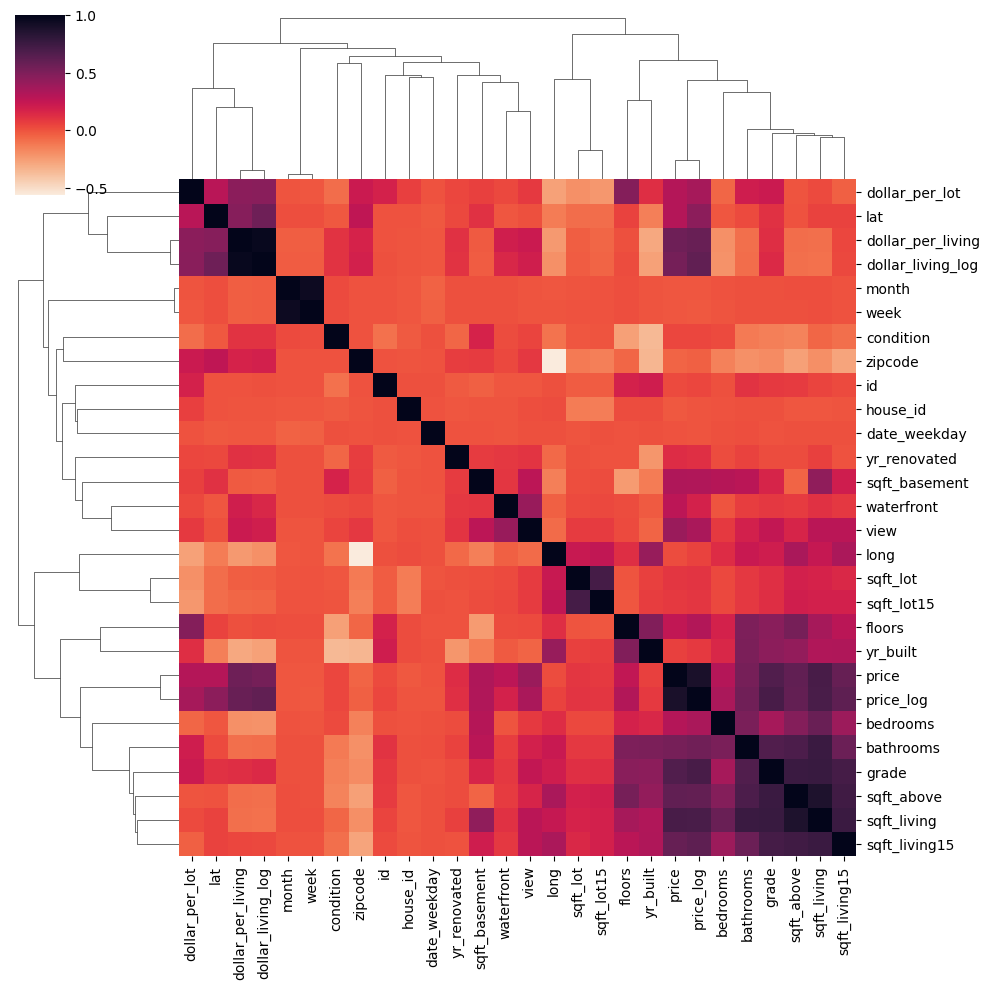

In [20]:
sns_plot = sns.clustermap(df_housing.corr(), cmap="rocket_r")
df_num_corr = df_housing.corr()['price'][1:]
expensive_features = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
expensive_features

price_log   is irrelevant since this is derived from the price
sqft_living          
grade                
sqft_above           
sqft_living15        
dollar_per_living    irrelevant since it is derived from price 
dollar_living_log    irrelevant since it is derived from price 
bathrooms     

# Lets start to narrow it down onto the groups my client is actually interested in 
First one being the "best neighborhoods"
I artificially define it as the zip codes with the highest average grade and price/sqft

In [21]:
df_grade = df_housing[['zipcode','id', 'dollar_per_living', "grade", 'price']].groupby(['zipcode']).agg({'dollar_per_living': 'median', 'grade': 'median', 'price':'median'}).reset_index()
df_grade.sort_values(['grade','price'], ascending=False).head(11)

,zipcode,dollar_per_living,grade,price
24,98039,565.165614,9.0,1895000.0
3,98004,456.944444,9.0,1150000.0
25,98040,376.370822,9.0,993750.0
5,98006,288.232917,9.0,760184.5
38,98075,250.830233,9.0,739999.0
39,98077,242.218905,9.0,652475.0
37,98074,255.351682,9.0,642000.0
48,98112,424.242424,8.0,915000.0
4,98005,316.340431,8.0,765475.0
53,98119,416.652778,8.0,744975.0


In [22]:
df_grade_2 = df_grade[(df_grade['grade'] > df_grade['grade'].median())].reset_index()
df_grade_3 = df_grade_2.sort_values(['price'], ascending=False).reset_index().head(15)
#df_grade_2 contains the zipcodes with the highest average price per sqft and price per lot
best_neighbourhood = list(df_grade_3['zipcode'])
best_neighbourhood

[98039,
 98004,
 98040,
 98112,
 98005,
 98006,
 98119,
 98075,
 98109,
 98102,
 98199,
 98033,
 98105,
 98077,
 98074]

In [23]:
# now we can make a new data frame only consisting of houses in the best neighborhood
# zip codes and then plot then geographically to see if our approach made sense 
# for this we will use my most favourite lambda and apply function
df_best = pd.concat(list(map(lambda x : df_housing[df_housing['zipcode'] == x], best_neighbourhood)))
df_best.head()
df_best.describe()

,price,house_id,id,bedrooms,bathrooms,sqft_lot,sqft_living,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,date_weekday,month,week,dollar_per_lot,dollar_per_living,price_log,dollar_living_log
count,3.957000e+03,3.957000e+03,3957.000000,3957.000000,3957.000000,3957.000000,3957.000000,3957.000000,3510.000000,3949.000000,...,3957.000000,3957.000000,3957.000000,3957.000000,3957.000000,3957.000000,3957.000000,3957.000000,3957.000000,3957.000000
mean,9.092076e+05,4.347073e+09,10611.014405,3.645691,2.448951,13442.195855,2624.168057,1.596285,0.010826,0.365662,...,-122.196012,2482.128633,12062.244882,1.988375,6.626990,27.044731,129.676501,354.253390,5.907321,2.526686
std,5.431937e+05,2.850624e+09,6148.936824,0.940771,0.835959,21413.226506,1122.402412,0.529183,0.103499,0.928822,...,0.118064,790.433765,15452.378405,1.459728,3.063923,13.265252,120.515716,119.600127,0.198928,0.138391
min,1.300000e+05,3.100016e+07,5.000000,1.000000,0.750000,520.000000,530.000000,1.000000,0.000000,0.000000,...,-122.416000,1000.000000,794.000000,0.000000,1.000000,1.000000,0.963321,90.750825,5.113943,1.957851
25%,5.950000e+05,1.923000e+09,5217.000000,3.000000,2.000000,5419.000000,1800.000000,1.000000,0.000000,0.000000,...,-122.293000,1860.000000,5450.000000,1.000000,4.000000,17.000000,57.494534,263.993399,5.774517,2.421593
50%,7.650000e+05,3.758900e+09,10589.000000,4.000000,2.500000,9000.000000,2470.000000,2.000000,0.000000,0.000000,...,-122.195000,2400.000000,9000.000000,2.000000,6.000000,26.000000,94.927536,327.319588,5.883661,2.514972
75%,1.010000e+06,6.848200e+09,16000.000000,4.000000,2.750000,13209.000000,3230.000000,2.000000,0.000000,0.000000,...,-122.094000,2990.000000,12268.000000,3.000000,9.000000,38.000000,159.807656,416.370107,6.004321,2.619480
max,7.700000e+06,9.831201e+09,21585.000000,10.000000,8.000000,368517.000000,12050.000000,3.500000,1.000000,4.000000,...,-121.965000,6110.000000,266587.000000,6.000000,12.000000,52.000000,2019.704433,800.000000,6.886491,2.903090


In [24]:
#Distribution of house age over the area
fig_best_neigbourhood = px.scatter_mapbox(df_best, 
                    lat='lat',
                    lon='long',
                    color='dollar_per_living', # which column to use to set the color of markers
                    hover_name="zipcode", # column added to hover information
                    #size="p", # size of markers
                    #color_continuous_scale=px.colors.cyclical.IceFire, 
                    size_max=15, zoom=10
                     )
#fig.update_layout(mapbox_style="open-street-map")

fig_best_neigbourhood.update_layout(mapbox_style="open-street-map")
fig_best_neigbourhood.update_layout(margin={"r":0.5,"t":0.5,"l":0.5,"b":0.5})

fig_best_neigbourhood.show()
fig_best_neigbourhood.write_image("graphics/fig_best_neigbourhood.pdf")

Looks good to me 

In [48]:
df_best_1 = df_best[['date', 'price','price_log' ,'house_id', 'bedrooms','bathrooms', 'sqft_lot',
        'sqft_living', 'floors', 'grade', 'yr_built', 'yr_renovated', 'zipcode',
        'lat', 'long', 'sqft_living15', 'sqft_lot15', 'date_weekday',
        'dollar_per_living','dollar_living_log', 'dollar_per_lot']]


He also owns historical buildings. There are definitions for the US: 
Buildings older than 50 years can qualify as historical 

In [50]:
df_best_1 = df_best_1[df_best_1['yr_built'] < 1964]

In [51]:
fig_best_history = px.scatter_mapbox(df_best_1, 
                    lat='lat',
                    lon='long',
                    color='dollar_per_living', # which column to use to set the color of markers
                    hover_name="zipcode", # column added to hover information
                    #size="p", # size of markers
                    #color_continuous_scale=px.colors.cyclical.IceFire, 
                    size_max=15, zoom=10
                     )
#fig.update_layout(mapbox_style="open-street-map")

fig_best_history.update_layout(mapbox_style="open-street-map")
fig_best_history.update_layout(margin={"r":0.5,"t":0.5,"l":0.5,"b":0.5})

fig_best_history.show()
fig_best_history.write_image("graphics/fig_best_history.pdf")

Now I want to see if the features I found before also correlate with the price in my particular subset of the data 

In [52]:
# plot the grade vs the price 
fig_gradevsprice = px.scatter(df_best, x='grade', y='price_log',  trendline="ols", labels=dict(grade="Grade of house", price_log="Average price (log10)"))

fig_gradevsprice.write_image("graphics/fig_gradevsprice.pdf")
fig_gradevsprice.show()

In [53]:
fig_bathroomsvsprice = px.scatter(df_best, x='bathrooms', y='price_log',  trendline="ols", labels=dict(bathrooms="Bathrooms per house", price_log="Average price (log10)"))

fig_bathroomsvsprice.write_image("graphics/fig_bathroomsvsprice.pdf")
fig_bathroomsvsprice.show()

In [54]:
fig_abovesvsprice = px.scatter(df_best, x='sqft_above', y='price_log',  trendline="ols", labels=dict(sqft_above="Area above", price_log="Average price (log10)"))
fig_abovesvsprice.write_image("graphics/fig_abovesvsprice.pdf")
fig_abovesvsprice.show()

In [31]:
fig_livingvsprice = px.scatter(df_best, x='sqft_living', y='price_log',  trendline="ols", labels=dict(sqft_living="Living area (sqft) ", price_log="Average price (log10)"))
fig_livingvsprice.write_image("graphics/fig_livingvsprice.pdf")
fig_livingvsprice.show()

In [32]:
fig_li15vsprice = px.scatter(df_best, x='sqft_living15', y='price_log',  trendline="ols", labels=dict(sqft_living15="Living area of the 15 neighbors (sqft) ", price_log="Average price (log10)"))
fig_li15vsprice.write_image("graphics/fig_li15vsprice.pdf")
fig_li15vsprice.show()

My cleint is also interested in finding the best time during the year to sell and to sell with biggest profit. So i will group by date 

In [33]:
df_best_time = df_best.groupby(['date']).agg({'dollar_per_living':'median', 'dollar_living_log':"median", 'house_id':'count', 'date_weekday': 'median', 'price_log': 'median', 'price':'median'}).reset_index()
df_best_time

,date,dollar_per_living,dollar_living_log,house_id,date_weekday,price_log,price
0,2014-05-02,295.833333,2.471004,12,4.0,5.755055,569250.0
1,2014-05-05,342.512309,2.534595,20,0.0,5.894035,783500.0
2,2014-05-06,291.566265,2.464737,19,1.0,5.829304,675000.0
3,2014-05-07,392.045455,2.593336,19,2.0,5.879669,758000.0
4,2014-05-08,333.612565,2.523163,20,3.0,5.829337,676250.0
...,...,...,...,...,...,...,...
315,2015-05-08,372.492837,2.571118,9,4.0,5.886491,770000.0
316,2015-05-09,341.176471,2.532979,1,5.0,5.909556,812000.0
317,2015-05-11,375.000000,2.574031,5,0.0,5.954243,900000.0
318,2015-05-12,377.904040,2.576477,8,1.0,5.940721,872500.0


In [34]:
fig_price_year = px.scatter(df_best_time, x = 'date' , y= 'dollar_living_log', trendline='rolling', trendline_options=dict(window=3),labels=dict(date="Date", dollar_living_log="Average price/sqft (log10)"))
fig_price_year

fig_price_year.write_image("graphics/fig_price_sqft_year.pdf")
fig_price_year.show()

No obvious pattern visible. We would need more data or better tools 

In [55]:
fig_price_year_orice = px.scatter(df_best_time, x = 'date' , y= 'price_log', trendline='rolling', trendline_options=dict(window=3),labels=dict(date="Date", price_log="Average price (log10)"))


fig_price_year_orice.write_image("graphics/fig_price_year_orice.pdf")
fig_price_year_orice.show()

Same here 

Lets look at the number of houses sold each day maybe there are better times to get you house on the market 

In [57]:
df_best_time_rolling = df_best_time.copy()
df_best_time_rolling['house_id'] = df_best_time_rolling.house_id.rolling(5).mean()
fig_sold_year = px.line(df_best_time_rolling, x = 'date' , y= 'house_id',labels=dict(date="Date", house_id="Houses sold per day"))

fig_sold_year.write_image("graphics/fig_sold_year.pdf")
fig_sold_year.show()

Interesting to see the numbers are low in between the years until Feb. Something to keep in mind. 
It might be that there is a week pattern 

In [58]:
df_best_dat = df_best_time.groupby(['date_weekday']).agg({'price_log':'median','house_id':'mean','price':'median','dollar_per_living':'median'}).reset_index()
df_best_dat

,date_weekday,price_log,house_id,price,dollar_per_living
0,0.0,5.887123,14.711538,771560.25,326.763955
1,1.0,5.890307,16.500000,777000.00,329.401755
2,2.0,5.887454,15.092593,771725.00,314.935861
3,3.0,5.887843,14.460000,772500.00,335.250727
4,4.0,5.885076,12.481481,767500.00,329.698582
5,5.0,5.916454,1.575758,825000.00,353.562437
6,6.0,5.891612,1.608696,782500.00,279.081633


In [38]:
weekdays = {0: 'Monday',
            1 : 'Tuesday',
            2: 'Wednesday',
            3: 'Thursday',
            4: 'Friday',
            5: 'Saturday',
            6: 'Sunday'}

df_best_dat['weekday'] = df_best_dat['date_weekday'].map(weekdays)

In [39]:
fig_best_day = px.line(df_best_dat, x = 'weekday' , y='house_id',labels=dict(date_weekday="Date", house_id="Average houses sold per day"))
fig_best_day.show()

fig_best_day.write_image("graphics/fig_best_day.pdf")

No surprise not many houses are sold on the weekend 

Now we should look at the impact of renovation on the price 

In [60]:
df_trial = df_best_1.copy()

#df_trial.dropna(axis=0, inplace=True)
#df_trial.head()
#df_trial_2.head()
df_trial = df_trial.fillna(-1)

In [61]:
df_trial['renovated'] = df_trial['yr_renovated'].apply(lambda x: 'Yes' if x>0 else 'No' if x >=0 else 'data not available')
df_trial.head()

,date,price,price_log,house_id,bedrooms,bathrooms,sqft_lot,sqft_living,floors,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,date_weekday,dollar_per_living,dollar_living_log,dollar_per_lot,renovated
4073,2014-11-07,875000.0,5.942008,3262300940,3.0,1.00,8119.0,1220.0,1.0,7,...,98039,47.6328,-122.236,1910.0,8119.0,4,717.213115,2.855648,107.771893,data not available
4074,2015-02-10,940000.0,5.973128,3262300940,3.0,1.00,8119.0,1220.0,1.0,7,...,98039,47.6328,-122.236,1910.0,8119.0,1,770.491803,2.886768,115.777805,data not available
4787,2015-03-24,937500.0,5.971971,2210500019,3.0,1.00,8500.0,1320.0,1.0,7,...,98039,47.6187,-122.226,2790.0,10800.0,1,710.227273,2.851397,110.294118,data not available
5173,2015-04-06,1160000.0,6.064458,6447300345,4.0,3.00,15438.0,2680.0,2.0,8,...,98039,47.6109,-122.226,4480.0,14406.0,0,432.835821,2.636323,75.139267,Yes
5584,2014-11-06,1880000.0,6.274158,6447300225,3.0,2.75,17919.0,2620.0,1.0,9,...,98039,47.6144,-122.228,3400.0,14400.0,3,717.557252,2.855857,104.916569,No


In [62]:
df_renovated = df_trial.groupby(['renovated']).agg({'house_id':'count', 'price':'mean', 'price_log': 'mean', 'dollar_per_living': 'mean', 'dollar_living_log':'mean'}).reset_index()
df_renovated.head()

,renovated,house_id,price,price_log,dollar_per_living,dollar_living_log
0,No,1068,8.521271e+05,5.884257,407.633719,2.591086
1,Yes,169,1.197563e+06,6.004075,424.908270,2.609057
2,data not available,248,8.577291e+05,5.886101,421.955330,2.606074


In [63]:
gig_best_hist_reno =px.bar(df_renovated, x='renovated', y='price_log',color='renovated' , labels=dict(renovated="Renovated", price_log="Average price (log10)"))
gig_best_hist_reno.write_image("graphics/gig_best_hist_reno.pdf")
gig_best_hist_reno.show()

In [64]:
gig_best_hist_reno_dollar =px.bar(df_renovated, x='renovated', y='dollar_living_log',color='renovated' , labels=dict(renovated="Renovated", dollar_living_log="Average price/sqft (log10)"))
gig_best_hist_reno_dollar.write_image("graphics/gig_best_hist_reno_dollar.pdf")
gig_best_hist_reno_dollar.show()

In [65]:
df_full = df_housing # jus
df_no = df_full.fillna(-1)
df_no['renovated'] = df_no['yr_renovated'].apply(lambda x: 'Yes' if x>0 else 'No' if x >=0 else 'not available')
df_no.head()

,date,price,house_id,id,bedrooms,bathrooms,sqft_lot,sqft_living,floors,waterfront,...,sqft_living15,sqft_lot15,date_weekday,month,week,dollar_per_lot,dollar_per_living,price_log,dollar_living_log,renovated
0,2014-10-13,221900.0,7129300520,1,3.0,1.00,5650.0,1180.0,1.0,-1.0,...,1340.0,5650.0,0,10,42,39.274336,188.050847,5.346157,2.274275,No
1,2014-12-09,538000.0,6414100192,2,3.0,2.25,7242.0,2570.0,2.0,0.0,...,1690.0,7639.0,1,12,50,74.288870,209.338521,5.730782,2.320849,Yes
2,2015-02-25,180000.0,5631500400,3,2.0,1.00,10000.0,770.0,1.0,0.0,...,2720.0,8062.0,2,2,9,18.000000,233.766234,5.255273,2.368782,not available
3,2014-12-09,604000.0,2487200875,4,4.0,3.00,5000.0,1960.0,1.0,0.0,...,1360.0,5000.0,1,12,50,120.800000,308.163265,5.781037,2.488781,No
4,2015-02-18,510000.0,1954400510,5,3.0,2.00,8080.0,1680.0,1.0,0.0,...,1800.0,7503.0,2,2,8,63.118812,303.571429,5.707570,2.482261,No


In [66]:
df_renovated_alt = df_no[['renovated','dollar_living_log','price_log']].groupby(['renovated']).agg({'dollar_living_log':'mean', 'price_log':'mean'}).reset_index()
df_renovated_alt

,renovated,dollar_living_log,price_log
0,No,2.383337,5.661756
1,Yes,2.470525,5.795733
2,not available,2.390011,5.663972


In [67]:
all_renovated = px.bar(df_renovated_alt, x='renovated', y='price_log',color='renovated' , labels=dict(renovated="Renovated", price_log="Average price (log10)"))
all_renovated.write_image("graphics/all_renovated.pdf")
all_renovated.show()